# Predicting Insurance Costs
For this project we will be looking at the Medical Costs dataset from kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For our regression problem, we are interested in how these different characteristics relate to the total medical costs. We want to construct the best possible predictive model for the cost, given some information about the patient.

Let us get started by importing the required Python Libraries:

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

We can now read in our **insurance** dataset using pandas Library:

In [28]:
# Read in insurance dataset
df = pd.read_csv(r"D:\Work_Shop\Data_Analytics_Project_3\insurance.csv")

# Display the first five rows
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Explore and Prepare the Data

### Check for Missing Data

In [29]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Our dataset does not have missing data

### Check for Duplicates

In [30]:
df.duplicated().sum()

1

Our dataset has got **1** duplicate. Let us remove the duplicate.

In [32]:
df.drop_duplicates(inplace = True)

# Check for duplicates again
df.duplicated().sum()

0

Our dataset is now without duplicates and missing data. 

### Display correlation between variables

In [35]:
df.corr(numeric_only = True)

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


From the Table we can see that there are no two variables with strong correlation. However, the correlation between **charges** and **age** which is about **30%** will need further inspection as it is trying to tell us something. Let us observe the corretion between **charges** and categorical variables. 

**NB**: We are comparing other variables to **charges** because **charges** has been choosen to be a dependent variable.

Let us display the distribution of charges as we may get some insights as to whether there are no attributes that are making our charges column to show weak correlation with other variables or not.

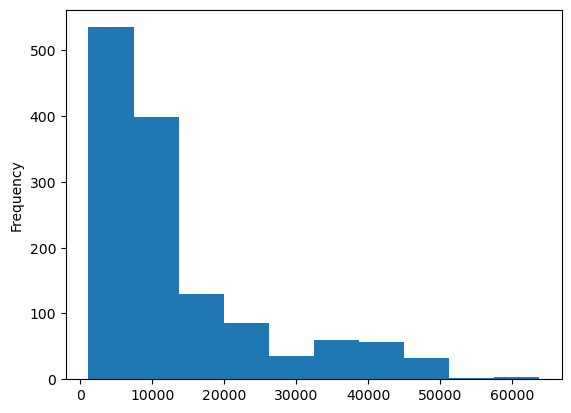

In [36]:
# Plot a Histogram
df['charges'].plot.hist()
plt.show()

The distribution is skewed to the right, an indication that there are more extremely high **charges** than they are extremely low charges. This has the ability of affecting how residual values are offseting each other. There is no balance. The expectation is for the residual values to cancel each other from both sides of the a regression line. Let us add a new column to our dataset. The new column will be the **log** of charges column. We will display the distribution of our new column and we will recalculate the correlation.

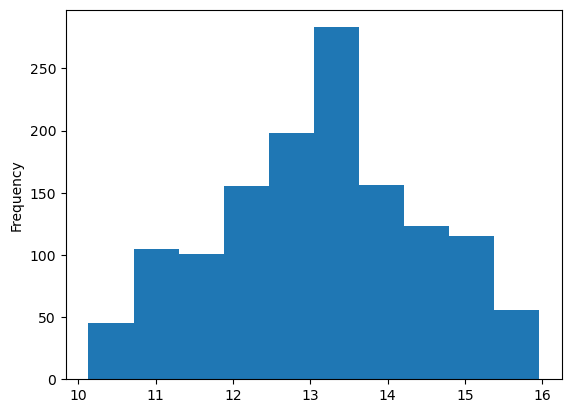

In [40]:
# Add a log_charges column
import numpy as np
df['log_charges'] = np.log2(df['charges'])

# Display the distribution of our new column
df['log_charges'].plot.hist()
plt.show()

We now have a distribution that is almost **normal**. This distribution is more likely to produce less residual values than the previous one. Let us display the correlations now.

In [42]:
# Correlation Table
df.corr(numeric_only = True)

,age,bmi,children,charges,log_charges
age,1.000000,0.109344,0.041536,0.298308,0.526927
bmi,0.109344,1.000000,0.012755,0.198401,0.132822
children,0.041536,0.012755,1.000000,0.067389,0.160336
charges,0.298308,0.198401,0.067389,1.000000,0.893084
log_charges,0.526927,0.132822,0.160336,0.893084,1.000000


We can now see that correlation between **log_charges** and **age** (**50%**)is now higher than that of **charges** and **age**. We are going to use **log_charges** for our predictions. 

Let us now check the correlation between the **log_charges** with categorical variables in our dataset.

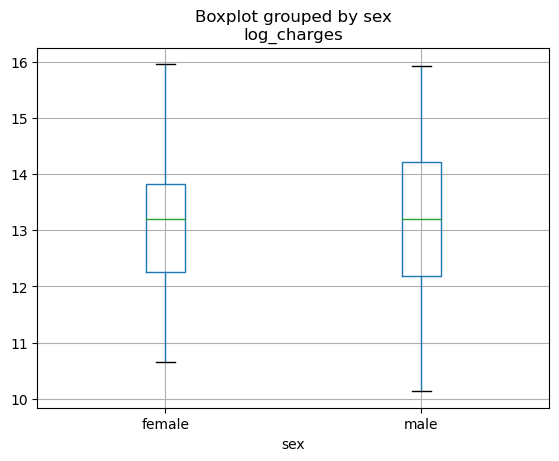

In [46]:
# Boxplot of log_charges and sex
df.boxplot(column = ['log_charges'], by = 'sex')
plt.show()

There is a wider distribution of charges for **male** patients. However, we cannot explicitly tell the relationship between **log_charges** and **sex** columns.

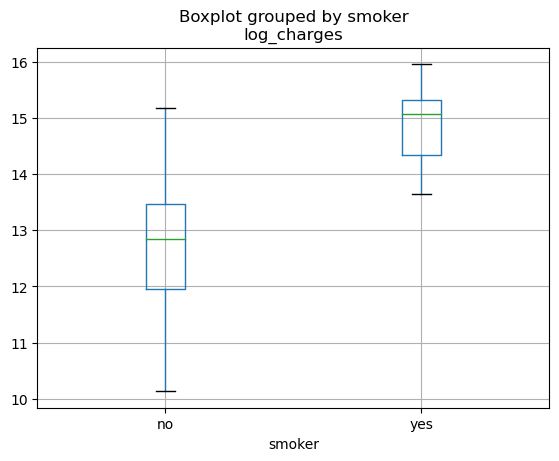

In [49]:
# "log_charges" and "smoker"
df.boxplot(column = 'log_charges', by = 'smoker')
plt.show()

There is an explicit relationship between **log_charges** and **smoker**. It seems those who smoke are charged higher. We will use his column in our prediction.

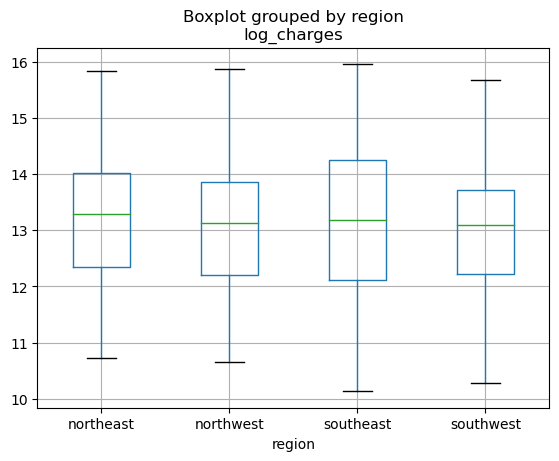

In [50]:
# log_charges and region
df.boxplot(column = 'log_charges', by = 'region')
plt.show()

There is also no visisble relationship between **log_charges** and **region**,therefore we are not going to use this column.

Let us now **feature engineer** smoker column. The intention is to convert the variable make it suitable for regression analysis. We are going to convert **yes** to **1** and **no** to **0**.

In [52]:
# Feature Engineering smoker column
df = pd.get_dummies(df, columns = ['smoker'])


,age,sex,bmi,children,region,charges,log_charges,smoker_no,smoker_yes
0,19,female,27.900,0,southwest,16884.92400,14.043448,0,1
1,18,male,33.770,1,southeast,1725.55230,10.752842,1,0
2,28,male,33.000,3,southeast,4449.46200,12.119415,1,0
3,33,male,22.705,0,northwest,21984.47061,14.424197,1,0
4,32,male,28.880,0,northwest,3866.85520,11.916945,1,0


We have introduced two new columns in our dataset: **smoker_no** and **smoker_yes**. We are going to use **smoker_yes** column.

Our model will consist of three variables from the dataset: **log_charges**, **age**, and **smoker_yes**.

## Dividing the dataset

We will first divid our dataset into a **target** variable and **feature** variables. 

Our target (dependent) variable is **log_charges** and the rest will be **feature** variables.

In [53]:
# Target variable
y = df['log_charges']

# Feature variables
X = df.drop(['log_charges'], axis = 1)

### Spliting our Dataset into Training sets and Testing sets

In [54]:
# Spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=674)

# Display the chape of our new datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep = "\n")

(1069, 8)
(268, 8)
(1069,)
(268,)


### Creating Subsets 

In [58]:
# X_train subset
X_train_subset = X_train[['age', 'smoker_yes']]

# X_test subset
X_test_subset = X_test[['age', 'smoker_yes']]

# Display the shape of subsets
print(X_test_subset.shape, X_train_subset.shape, sep = "\n")

(268, 2)
(1069, 2)


### Fitting the Model

In [59]:
# Instantiating the Linear Regression object
model = LinearRegression()

# Fitting the model
model.fit(X_train_subset, y_train)

LinearRegression()

Now that we have our model, we can use it for making predictions. Before we use our model for prediction, let us display the estimated **intercept** and **coefficients** of our model.

In [63]:
# Intercept
intercept = model.intercept_

# coefficients
coefficients = model.coef_

print(f"The Coeffients of our model are: {coefficients}")
print(f"The Intercept for our model is: {intercept}")

The Coeffients of our model are: [0.04946947 2.2216724 ]
The Intercept for our model is: 10.757583699081843


We will not yet interpret the coefficients untill we run some test to make sure our model is a good model and ready for use. We will use **R Squared** goodness of fit measure. 

In [64]:
# R_squared for Training data
r_square_training_data = model.score(X_train_subset, y_train)

# R_squared for Testing data
r_square_testing_data = model.score(X_test_subset, y_test)

# Display the R_squares scores
print(r_square_training_data, r_square_testing_data, sep = "\n")

0.72193160925696
0.7997280587908229


As determined by the **Goodness of Fit** (R Squares) above, our model is somewhat a good model to be used for prediction. However, our model may still need some touch up because we have only used two features as determinants of insurance charges while in real sense there are many variables determing insurance charges. There are also many Machine Learning models that can be used to predict insurance cost.

### Interpretation of Coefficients

1. A one year increase in a patient's age results into **5%** increase in insurance charges.
2. If a patient is a smoker, his or her insurance charges will increase by **822%**

## Conclusion

We can go ahead and use the model for prediction. The above figures are supposed to be tested for significance, however, the main purpose of this project was to predict the model. 